In [ ]:
# default_exp funcs.exp_specific

In [ ]:
%load_ext autoreload
%autoreload 2

# Dataset specific functions, mostly for dataloading

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.utils import *
from tifffile import imread
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.psf import crop_psf
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.dataset import *
from torch.utils.data import DataLoader
from collections.abc import MutableSequence

In [ ]:
#export
def simfish_to_df(sim_file, frame_idx=0, int_fac=1.05):
    
    yxzi = []
    with open(sim_file) as f:
        read = False
        for line in f:
            if 'Pos_Y' in line: 
                read = True
                continue
            if 'SPOTS_END' in line: break
            if read: yxzi.append([float(s) for s in line.split()])

    yxzi = np.array(yxzi)#/px_size
    loc_idx = np.arange(len(yxzi))
    # Number calculated by taking into account their (or my?) normalization (by max and not by sum)
    if yxzi.shape[1] == 4:
        # PSF.max() | PSF.sum() | 3**3 (superres)  | PSF.max() | microscope scale
        # ints = yxzi[:,3] * 65535.0 * 156772560.0 / 27 / 65535.0 / 10000.0
        ints = yxzi[:,3] * 65535.0 / 100.0 / int_fac
    else:
        ints = np.ones_like(loc_idx)
    
    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': frame_idx,
                       'x': yxzi[:,1],
                       'y': yxzi[:,0], 
                       'z': yxzi[:,2], 
                       'prob': np.ones_like(loc_idx), 
                       'int': ints, 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})

    return df   


def matlab_fq_to_df(resfile, frame_idx=0):
    
    ind_dict = {'x':1, 'y':0, 'z':2, 'int':3, 'x_sig':6, 'y_sig':7, 'z_sig':8}
    
    yxzi = []
    with open(resfile) as f:
        read = False
        for line in f:
            if 'Pos_Y' in line: 
                read = True
                continue
            if 'SPOTS_END' in line: break
            if read: yxzi.append([float(s) for s in line.split()])

    yxzi = np.array(yxzi)#/px_size
    loc_idx = np.arange(len(yxzi))
    
    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': frame_idx,
                       'x': yxzi[:,ind_dict['x']],
                       'y': yxzi[:,ind_dict['y']], 
                       'z': yxzi[:,ind_dict['z']], 
                       'prob': np.ones_like(loc_idx), 
                       'int': yxzi[:,ind_dict['int']], 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': yxzi[:,ind_dict['x_sig']], 
                       'y_sig': yxzi[:,ind_dict['y_sig']], 
                       'z_sig': yxzi[:,ind_dict['z_sig']],
                       'comb_sig' : np.sqrt(yxzi[:,ind_dict['x_sig']]**2
                                              +yxzi[:,ind_dict['y_sig']]**2
                                              +yxzi[:,ind_dict['z_sig']]**2)})

    return df 

#export 
def load_sim_fish(basedir, mrna_lvl=200, shape='cell3D', exp_strength='strong', cell_nr=0, shift=[-38,-38,-110], int_fac=1.05):
    
    spec_dir = f'/mRNAlevel_{mrna_lvl}/{shape}/{exp_strength}/'
    img_path = sorted(glob.glob(basedir + spec_dir + 'w1*.tif'))[cell_nr]
    cellname = Path(img_path).name.split('.')[0]
#     print(name)
    img = load_tiff_image(img_path)
    gt_df = simfish_to_df(img_path.split('.')[0] + '.txt', int_fac=int_fac)
    fq_nog_df = fq_gmm_df = DF()
    if os.path.exists(basedir + '/_results_detection/'):
        nog_path = Path(basedir + '/_results_detection/' + spec_dir + '/results_noGMM/' + cellname + '_res_NO_GMM.txt')
        gmm_path = Path(basedir + '/_results_detection/' + spec_dir + '/results_GMM/' + cellname + '_res_GMM.txt')

        if nog_path.is_file(): 
            fq_nog_df = simfish_to_df(nog_path, int_fac=int_fac)
            fq_nog_df = shift_df(fq_nog_df, shift)
        if gmm_path.is_file(): 
            fq_gmm_df = simfish_to_df(gmm_path, int_fac=int_fac)
            fq_gmm_df = shift_df(fq_gmm_df, shift)
        
    return img, gt_df, fq_nog_df, fq_gmm_df

#export
def big_fishq_to_df(file_str):
    
    csv = pd.read_csv(file_str,sep=';',names=['z','y','x'], index_col=False)

    zyx = np.array(csv)
    loc_idx = np.arange(len(zyx))

    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': np.zeros_like(loc_idx),
                       'x': zyx[:,2],
                       'y': zyx[:,1], 
                       'z': zyx[:,0], 
                       'prob': np.ones_like(loc_idx), 
                       'int': np.ones_like(loc_idx), 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})
    
    return df

def rsfish_to_df(file_str):
    
    csv = pd.read_csv(file_str,sep='  ',names=['x','y','z','?','??'], index_col=False)
    
    xyz = np.array(csv)
    loc_idx = np.arange(len(xyz))

    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': np.zeros_like(loc_idx),
                       'x': xyz[:,1],
                       'y': xyz[:,0], 
                       'z': xyz[:,2], 
                       'prob': np.ones_like(loc_idx), 
                       'int': np.ones_like(loc_idx), 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})
    
    return df

In [ ]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'
img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 250, 'random', 'NR', 2)

In [ ]:
# load_big_fishq('deepstorm/datasets/CodFish/smFISH_data_Titlow/detections/sgg_smFISH_4_spots.csv')
f_name = '../../../deepstorm/datasets/CodFish/smFISH_data_Titlow/detections/sgg_smFISH_4_spots.csv'
tiff = load_tiff_image(Path(f_name).parent.parent/'sgg_smFISH_4.tif')
print(tiff.shape)

df = big_fishq_to_df(f_name)

torch.Size([1, 25, 512, 512])


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


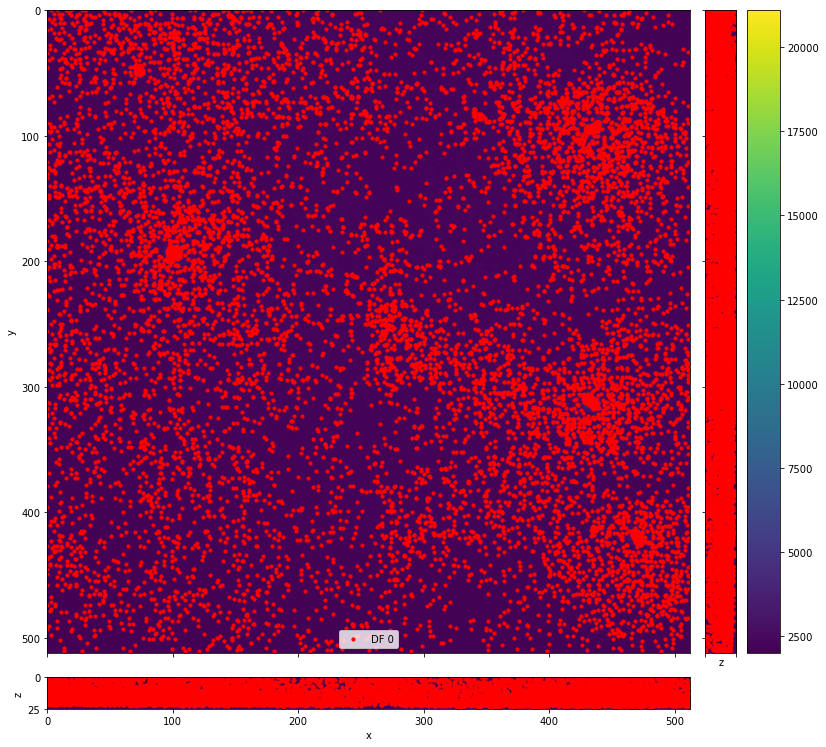

In [ ]:
from decode_fish.funcs.plotting import *
from decode_fish.funcs.emitter_io import *

fig, axes = plot_3d_projections(tiff[0], size=10)
scat_3d_projections(axes, [df])

In [ ]:
# import tifffile
img = read_MOp_tiff('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif', True)
ch_sum = cpu(img).sum(-1).sum(-1).sum(-1)
ch_sum = ch_sum/ch_sum.min()

In [ ]:
# export
def get_MOp_scale():
    return np.array([4.560342 , 1.602575 , 1.1682607, 3.5678792, 3.5533457, 1.312987 ,
       3.4726021, 1.2291945, 1.3063799, 3.1166024, 3.2340987, 1.1336689,
       3.824306 , 1.       , 1.1696737, 3.9208868, 3.2251415, 1.1484412,
       3.372565 , 1.3232977, 1.0225794, 3.119445], dtype='float32')

def read_MOp_tiff(image_path, scaled=False):
    img_stack = imread(image_path, key=range(0,7*22))
    img_stack = img_stack.reshape([22,7,2048,2048]) 
    img_stack = torch.tensor(img_stack.astype('float32'))
    if scaled:
        img_stack /= get_MOp_scale()[:,None,None,None]
    return img_stack

In [ ]:
# export
def get_benchmark_from_starfish(magnitude_threshold=10**0.75*4):

    bench = pd.read_csv(
        io.BytesIO(requests.get('https://d2nhj9g34unfro.cloudfront.net/MERFISH/benchmark_results.csv').content),
        dtype={'barcode': object})

    #See Fig. S4 https://www.pnas.org/content/113/39/11046

    bench_df = bench.copy()
    bench_df = bench_df[bench_df['total_magnitude']>magnitude_threshold]
    bench_df = bench_df[bench_df['area']>3]

    print(len(bench_df))

    experiment = data.MERFISH(use_test_data=True)
    code_ref = experiment.codebook.data.reshape([140,-1], order='F')
    targets = experiment.codebook.indexes['target']
    
    bench_df.loc[:,'frame_idx'] = 0
    bench_df.loc[:,'loc_idx'] = np.arange(len(bench_df))
    bench_df.loc[:,'int'] = bench_df['total_magnitude']
    bench_df.loc[:,'z'] = 50/100
    bench_df = px_to_nm(bench_df)

    return bench_df, code_ref, targets

def get_benchmark(magnitude_threshold=10**0.75*4):

    bench = pd.read_csv(base_path + '/decode_fish/data/merfish_bench_df.csv')

    #See Fig. S4 https://www.pnas.org/content/113/39/11046

    bench_df = bench.copy()
    bench_df = bench_df[bench_df['total_magnitude']>magnitude_threshold]
    bench_df = bench_df[bench_df['area']>3]

    print(len(bench_df))
                        
    code_ref = np.load(base_path + '/decode_fish/data/merfish_code_ref.npz')['arr_0']
    targets = np.load(base_path + '/decode_fish/data/merfish_targets.npz', allow_pickle=True)['arr_0']
    
    bench_df.loc[:,'frame_idx'] = 0
    bench_df.loc[:,'code_inds'] = bench_df['barcode_id'].values - 1
    bench_df.loc[:,'loc_idx'] = np.arange(len(bench_df))
    bench_df.loc[:,'int'] = bench_df['total_magnitude']
    bench_df.loc[:,'z'] = 50/100
    bench_df = px_to_nm(bench_df)
    bench_df = bench_df.drop('barcode_id', axis=1)
    return bench_df, code_ref, targets

def get_istdeco():
    istdeco_df = pd.read_csv('../../decode_fish/data/results/ISTDECO.csv')
    istdeco_df = istdeco_df.rename(columns={'target_name':'gene'})
    fov = [40,40,2008,2008]
    istdeco_df = istdeco_df[ (istdeco_df['x'] >= fov[0]) & (istdeco_df['x'] <= fov[2])  & (istdeco_df['y'] >= fov[1]) & (istdeco_df['y'] <= fov[3])]
    
    istdeco_df.loc[:,'frame_idx'] = 0
    istdeco_df.loc[:,'code_inds'] = istdeco_df['target_id'].values - 1
    istdeco_df.loc[:,'loc_idx'] = np.arange(len(istdeco_df))
    istdeco_df.loc[:,'int'] = istdeco_df['intensity']
    istdeco_df.loc[:,'z'] = 50/100
    istdeco_df = px_to_nm(istdeco_df)
    istdeco_df = istdeco_df.drop('target_id', axis=1)
    
    print(len(istdeco_df))
    return istdeco_df

def get_merfish_mop(return_bench_df=False, mouse=1, sample=1, n_genes=252):

    mop_path = base_path +'/datasets/CodFish/MERFISH/MOp/'
    
    code_ref = pd.read_csv(mop_path + '/additional_files/codebook.csv')
    code_ref = code_ref.loc[:,code_ref.columns[2:]].values.astype('int8')
    targets = open(mop_path + '/additional_files/genes_combinatorial.txt').read().split('\n')
    targets = np.concatenate([targets, [f'Blank-{i}' for i in range(1,11)]])
    targets = np.array(targets).astype('object')
    
    if return_bench_df:
        bench_df = pd.read_csv(mop_path + f'spots_mouse{mouse}sample{sample}.csv')
        bench_df.columns = ['loc_idx', 'x', 'y', 'z', 'gene']
        bench_df['frame_idx'] = 0
        bench_df[['x','y','z']] = 1000*bench_df[['x','y','z']] # um to nm
        
        t_dict = {}
        for i,k in enumerate(targets):
            t_dict[k] = i
            
        code_inds = [t_dict[x] for x in bench_df['gene']]
        bench_df['code_inds'] = code_inds
        
        print(len(bench_df))
    else:
        bench_df = None

    return bench_df, code_ref[:n_genes], targets[:n_genes]

def get_mop_fov(bench_df, img_nr, mouse=1, sample=1):
    
    px_size = 108.5
    n_px = 2048    
    
    mop_path = base_path +'/datasets/CodFish/MERFISH/MOp/'
    fov_pos = np.genfromtxt(mop_path + f'/additional_files/fov_positions/mouse{mouse}_sample{sample}.txt', delimiter=',')
    
    fov_x = fov_pos[img_nr,0]*1000 # um to nm
    fov_y = fov_pos[img_nr,1]*1000
    bench_sub = crop_df(bench_df, np.s_[:,:,fov_y:fov_y+n_px*px_size,fov_x:fov_x+n_px*px_size])
    
    return bench_sub

def get_mop_colors():
    return np.array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0])

In [ ]:
data_org = pd.read_csv(base_path +'/datasets/CodFish/MERFISH/MOp/additional_files/data_organization_raw.csv', encoding='latin1')
np.array(data_org['color (nm)'] > 700)*1

array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0])

In [ ]:
bench_df, code_ref, targets = get_benchmark()
print(code_ref.dtype)
print(code_ref.shape)
print(targets.dtype)

13832
uint8
(140, 16)
object


In [ ]:
bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True)
print(code_ref.dtype)
print(code_ref.shape)
print(targets.dtype, len(targets))

17130008
int8
(252, 22)
object 252


In [ ]:
img = read_MOp_tiff('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images151.tif')

In [ ]:
bench_sub = get_mop_fov(bench_df, 150)

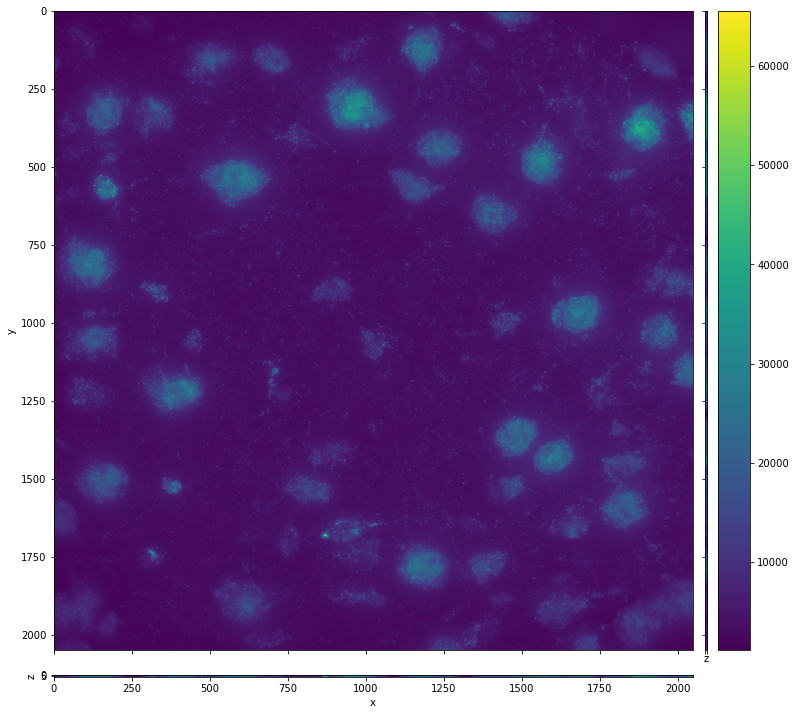

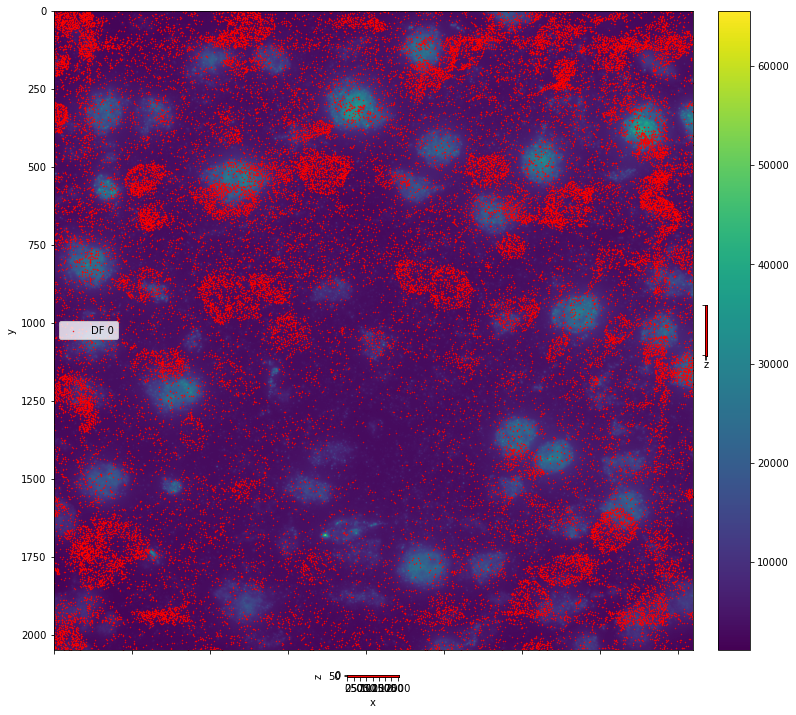

In [ ]:
from decode_fish.funcs.plotting import *
from decode_fish.funcs.emitter_io import *

fig, axes = plot_3d_projections(img[0], size=10)

fig, axes = plot_3d_projections(img[0], size=10)
scat_3d_projections(axes, [nm_to_px(bench_sub, [108.5,108.5,108.5])], s_fac=0.02)

# Custom eval funcs

In [ ]:
import tifffile
img = read_MOp_tiff('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif', scaled=True)
tifffile.imsave('../data/MOp_eval/eval_img.tif', np.array(img[:,:,500:1000,500:1000]))

[autoreload of decode_fish.engine.place_psfs failed: Traceback (most recent call last):
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 

In [ ]:
img = load_tiff_image('../data/MOp_eval/eval_img.tif')[None]

In [ ]:
from decode_fish.funcs.merfish_eval import *
import pandas as pd
bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True)
bench_df = get_mop_fov(bench_df, 150)
bench_df = nm_to_px(bench_df, [1.085,1.085,1.085])
bench_df['x'] += 70
bench_df['y'] += 70

bench_sub = crop_df(bench_df, np.s_[:,:,500:1000,500:1000], px_size_zyx=[100., 100., 100.])
bench_sub.to_csv('../data/MOp_eval/bench_df.csv')

17130008


In [ ]:
len(bench_sub)

3788

In [ ]:
# export
from decode_fish.funcs.predict import merfish_predict
from decode_fish.funcs.evaluation import matching
def exp_train_eval_starfish(model, post_proc, targets, path, top_n, wandb, batch_idx):
    '''Not tested'''

    res_df = merfish_predict(model, post_proc, [path], window_size=[None, 64, 64], device='cuda')
    res_df = exclude_borders(res_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])

    if len(res_df):

        res_df['gene'] = targets[res_df['code_inds']]
        res_df = res_df[res_df['gene'] != 'MALAT1']
        
        bench_df, _, _ = get_benchmark()
        bench_df = bench_df[bench_df['gene'] != 'MALAT1']

        res_sub = res_df.nsmallest(top_n, 'comb_sig')

        bench_counts = DF(data=None, index=targets)
        bench_counts['Res_all'] = res_sub.groupby('gene')['gene'].count()
        bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
        bench_counts = bench_counts.fillna(0)
        r = np.corrcoef(bench_counts['Bench_all'].values, bench_counts['Res_all'].values)[0, 1]   

        blinds = []
        for i,g in enumerate(targets):
            if 'Blank' in g:
                blinds.append(g)

        bc = bench_counts.loc[blinds,'Res_all'].values.sum()

        wandb.log({'AE Losses/code_bench_corr': r}, step=batch_idx)
        wandb.log({'AE Losses/N_blanks': bc}, step=batch_idx)
        
        perf_dict, match_df, shifts = matching(bench_df,  res_sub, tolerance=500, print_res=False)
        wandb.log({'AE Losses/precision': perf_dict['precision']}, step=batch_idx)
        wandb.log({'AE Losses/recall': perf_dict['recall']}, step=batch_idx)        
        wandb.log({'AE Losses/jaccard': perf_dict['jaccard']}, step=batch_idx)  

    wandb.log({'AE Losses/N_pred_tot': len(res_df)}, step=batch_idx)
    
def exp_train_eval_MOp(model, post_proc, targets, path, top_n, wandb, batch_idx):
    
    res_df = merfish_predict(model, post_proc, [path + '/eval_img.tif'], window_size=[None, 64, 64], device='cuda')
    res_df['gene'] = targets[res_df['code_inds']]

    if len(res_df):
    
        bench_df = pd.read_csv(path + '/bench_df.csv')
        res_sub = res_df.nsmallest(top_n, 'comb_sig')

        bench_counts = DF(data=None, index=targets)
        bench_counts['Res_all'] = res_sub.groupby('gene')['gene'].count()
        bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
        bench_counts = bench_counts.fillna(0)
        r = np.corrcoef(bench_counts['Bench_all'].values, bench_counts['Res_all'].values)[0, 1]   

        blinds = []
        for i,g in enumerate(targets):
            if 'Blank' in g:
                blinds.append(g)

        bc = bench_counts.loc[blinds,'Res_all'].values.sum()
        
        bench_df['z'] = bench_df['z']/1000
        res_sub['z'] = res_sub['z']/100
        
        
        wandb.log({'AE Losses/code_bench_corr': r}, step=batch_idx)
        wandb.log({'AE Losses/N_blanks': bc}, step=batch_idx)
        
        perf_dict, match_df, shifts = matching(bench_df,  res_sub, tolerance=500)
        wandb.log({'AE Losses/precision': perf_dict['precision']}, step=batch_idx)
        wandb.log({'AE Losses/recall': perf_dict['recall']}, step=batch_idx)        
        wandb.log({'AE Losses/jaccard': perf_dict['jaccard']}, step=batch_idx)        
        
    wandb.log({'AE Losses/N_pred_tot': len(res_df)}, step=batch_idx)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted index.ipynb.
